In [1]:
# Some useful imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import eval_hermitenorm, factorial
from scipy.stats import norm
from scipy.linalg import expm
from sympy import symbols, expand, sqrt, collect, Poly
from sympy import pprint, simplify
import sympy as sp
from math import sqrt

In [63]:
class JacobiPricing:
    def __init__(self, V0, V01, V02, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, Rho, Gamma, r):
        self.V0 = V0
        self.V01 = V01
        self.V02 = V02
        self.X0 = X0
        self.v_min = v_min
        self.v_max = v_max
        self.sigma = sigma
        self.rho = rho
        self.kappa = kappa
        self.theta = theta
        self.delta = delta
        self.mu_w = mu_w
        self.sigma_w = sigma_w
        self.Rho = Rho
        self.Gamma = Gamma
        self.r = r
        self.beta = 1 / (np.sqrt(self.v_max) - np.sqrt(self.v_min))**2

    def Q(self, v1, v2):
        V = self.V0 + self.Gamma[0] * v1 + self.Gamma[1] * v2
        return self.beta * (V - self.v_min) * (self.v_max - V)

    def monte_carlo(self, V0, X0, paths, f):
        values = f(paths[:, -1, 1]) 
        mean = np.mean(values)
        std = np.std(values, ddof=1)
        return mean, std


    def I_call(self, N, mu, nu):
        res = np.zeros(N+1)
        res[0] = np.exp(nu**2/2) * norm.cdf(nu-mu)
        for i in range(1, N+1):
            res[i] = eval_hermitenorm(i-1, mu) * np.exp(mu*nu) * norm.pdf(mu) + nu * res[i-1]
        return res

    def f_call(self, N, k, T):
        mu = (k-self.mu_w) / self.sigma_w
        nu = self.sigma_w
        I = self.I_call(N, mu, nu)
        f = np.zeros(N+1)
        f[0] = np.exp(-self.r*T+self.mu_w) * I[0] - np.exp(-self.r*T+k) * norm.cdf(-mu)
        for i in range(1, N+1):
            f[i] = np.exp(-self.r*T+self.mu_w) * (1/np.sqrt(factorial(i, exact=False))) * self.sigma_w * I[i-1]
        return f

    def G_polynomial(self, m, n, q):
        # Définition des variables symboliques
        v1, v2, x = sp.symbols('v1 v2 x')

        sigma = self.sigma
        rho = self.rho
        k = self.kappa
        theta = self.theta
        delta = self.delta
        r = self.r
        sigma_w = self.sigma_w
        beta = self.beta
        v_min = self.v_min
        v_max = self.v_max
        V0 = self.V0
        Gamma = self.Gamma
        r1 = self.Rho[0]
        r2 = self.Rho[1]
        g1 = self.Gamma[0]
        g2 = self.Gamma[1]

        V = V0 + Gamma[0] * v1 + Gamma[1] * v2
        Q = beta * (V - v_min) * (v_max - V)

        # Terme G1
        G1 = (
            (-r1 * v1 + k * (theta - V)) * m * v1**(m - 1) * v2**n * x**q
            + (-r2 * v2 + k * (theta - V)) * n * v1**m * v2**(n - 1) * x**q
            + (r - delta - V) * v1**m * v2**n * np.sqrt(q) / sigma_w * x**(q - 1)
        )

        # Terme G2
        G2 = (
            sigma**2 * Q * m * (m - 1) * v1**(m - 2) * v2**n * x**q
            + sigma**2 * Q * m * n * v1**(m - 1) * v2**(n - 1) * x**q
            + rho * sigma * Q * m * np.sqrt(q) / sigma_w * v1**(m - 1) * v2**n * x**(q - 1)
            + sigma**2 * Q * m * n * v1**(m - 1) * v2**(n - 1) * x**q
            + sigma**2 * Q * n * (n - 1) * v1**m * v2**(n - 2) * x**q
            + rho * sigma * Q * n * np.sqrt(q) / sigma_w * v1**m * v2**(n - 1) * x**(q - 1)
            + rho * sigma * Q * m * np.sqrt(q) / sigma_w * v1**(m - 1) * v2**n * x**(q - 1)
            + rho * sigma * Q * n * np.sqrt(q) / sigma_w * v1**m * v2**(n - 1) * x**(q - 1)
            + V * np.sqrt(q * (q - 1)) / sigma_w**2 * v1**m * v2**n * x**(q - 2)
        )

        G = G1 + (1 / 2) * G2

        return expand(sp.simplify(G))


    def pi(self, N):
        p = 0
        h = {}
        h_inv = []
        for d in range(0, N + 1):
            for i in range(0, d + 1):
                for j in range(0, d - i + 1):
                    h[(i, j, d - i - j)] = p
                    h_inv.append((i, j, d - i - j))
                    p += 1
        return h, np.array(h_inv)

    def H(self, m, n, q, v1, v2, x):
        return (v1**m) * (v2**n) * (1/np.sqrt(factorial(q, exact=False))) * eval_hermitenorm(q, (x-self.mu_w)/self.sigma_w)

    def l(self, N, T):
        v1, v2, x = symbols('v1 v2 x')
        
        M = (N + 1) * (N + 2) * (N + 3) // 6
        h, h_inv = self.pi(N)

        H_lst = np.zeros(M)
        for i in range(M):
            (m, n, q) = h_inv[i]
            H_lst[i] = self.H(m, n, q, self.V01, self.V02, self.X0)
        
        G_matrix = np.zeros((M, M))
        
        for d in range(0, N + 1):
            for i in range(0, d + 1):
                for j in range(0, d - i + 1):
                    m, n, q = i, j, d - i - j
                    G = self.G_polynomial(m, n, q)
                    coeff_dict = G.as_coefficients_dict()
                    for a in range(m-2, m+3):
                        for b in range(n-2, n+3):
                            for c in range(q-2, q+1):
                                if(a>=0 and a<=N and a>=0 and b<=N and b>=0 and b<=N and c>=0 and c<=N and a+b+c<=N):
                                    target_monom = v1**a * v2**b * x**c
                                    coeff = coeff_dict.get(target_monom, 0.)
                                    coeff_float = 0.
                                    if hasattr(coeff, 'evalf'):
                                        coeff_float = float(coeff.evalf())
                                    else:
                                        coeff_float = float(coeff)
                                    G_matrix[h[(a,b,c)], h[(m,n,q)]] = coeff_float
        E = np.zeros((M, N+1))
        for i in range(N+1):
            E[h[(0, 0, i)], i] = 1
        G_exp = expm(T * G_matrix) 

        l = H_lst @ G_exp @ E

        return l

    def price_call(self, N, k, T):
        f = self.f_call(N, k, T)
        l = self.l(N, T)
        return np.dot(f, l)

Test de la fonction polynôme

In [64]:

# Exemple d'initialisation avec des valeurs arbitraires
pricing = JacobiPricing(
    V0=0.5,
    V01=0.6,
    V02=0.7,
    X0=0.8,
    v_min=0.1,
    v_max=1.0,
    sigma=0.2,
    rho=0.3,
    kappa=1.5,
    theta=0.04,
    delta=0.02,
    mu_w=0.01,
    sigma_w=0.1,
    Rho=[0.1, 0.2],
    Gamma=[0.3, 0.4],
    r=0.05
)

# Choix de paramètres de test pour G_polynomial
m = 2
n = 1
q = 3

poly = pricing.G_polynomial(4, 7, 5)

print(poly)

for monome, coeff in poly.as_coefficients_dict().items():
    print(monome, float(coeff.evalf()))

v1, v2, x = sp.symbols('v1 v2 x')
target_monom = v1**2 * v2**7 * x**5

coeff_dict = poly.as_coefficients_dict()
coeff = coeff_dict.get(target_monom, 0)  # renvoie 0 si le monome n'existe pas
print(coeff)

-1.80781455755734*v1**6*v2**6*x**4 - 0.161695849656476*v1**6*v2**5*x**5 - 12.562079642685*v1**5*v2**7*x**4 + 67.0820393249937*v1**5*v2**7*x**3 - 3.79678339862591*v1**5*v2**6*x**5 + 0.602604852519112*v1**5*v2**6*x**4 + 0.0538986165521588*v1**5*v2**5*x**5 - 14.9129294968551*v1**4*v2**8*x**4 + 89.4427190999916*v1**4*v2**8*x**3 - 8.70857667902211*v1**4*v2**7*x**5 - 9.36170072754594*v1**4*v2**7*x**4 + 111.803398874989*v1**4*v2**7*x**3 - 4.68627035586091*v1**4*v2**6*x**5 + 4.01736568346075*v1**4*v2**6*x**4 + 0.359324110347725*v1**4*v2**5*x**5 - 1.83651002672491*v1**3*v2**9*x**4 - 2.90647588887108*v1**3*v2**8*x**5 + 0.459127506681228*v1**3*v2**8*x**4 - 2.64878063251142*v1**3*v2**7*x**5 + 2.29563753340614*v1**3*v2**7*x**4 + 0.479098813796967*v1**3*v2**6*x**5 - 0.0821312252223373*v1**2*v2**9*x**5 + 0.0205328063055843*v1**2*v2**8*x**5 + 0.102664031527922*v1**2*v2**7*x**5
v1**3*v2**7*x**4 2.2956375334061416
v1**2*v2**8*x**5 0.02053280630558431
v1**4*v2**6*x**4 4.017365683460747
v1**3*v2**8*x**4 0

In [ ]:
# Paramètres du modèle
V0 = 0.04
V01 = 0.
V02 = 0.
X0 = 0
v_min = 10**(-4)
v_max = 0.08
sigma = 1.
rho = -0.5
kappa = 0.5
theta = 0.04
delta = 0.
sigma_w = np.sqrt(0.003333333333333333)
mu_w = -0.0016666666666666666
Rho = np.array([0., 0.2]) 
Gamma = np.array([1., 0.05])
r = 0.    

# Paramètres du Call
k = 0.
T = 1/12
N = 1

# Modèle de Jacobi
model = JacobiPricing(V0, V01, V02, X0, v_min, v_max, sigma, rho, kappa, theta, delta, mu_w, sigma_w, Rho, Gamma, r)

price = model.price_call(N, k, T)
print(price)

0.022177219890792525


0.02302974467802421
0.022177219890792525
0.022393990718564714
0.022233740930531633
0.02138442658413366
0.02138697166815253
0.021492543749171505
0.02147080995420245


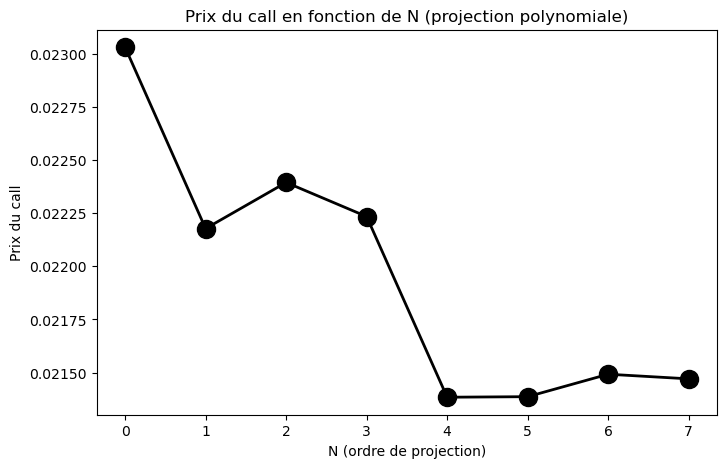

In [71]:
# Calcul du prix pour différents ordres N
N_vals = [i for i in range(8)]
prices = []

for N in N_vals:
    price = model.price_call(N, k, T)
    print(price)
    prices.append(price)

# Tracer la courbe
plt.figure(figsize=(8, 5))
plt.plot(N_vals, prices, marker='o', markersize=13, color='black', linewidth=2)
plt.title("Prix du call en fonction de N (projection polynomiale)")
plt.xlabel("N (ordre de projection)")
plt.ylabel("Prix du call")

# Forcer les ticks sur les N exacts
plt.xticks(N_vals)

plt.show()